In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# Pendulum dataset generation

In [2]:
def pendulum_generation(
                            theta_0,
                            omega_0,
                            ti,
                            m,
                            g,
                            l,
                            N
                       ):
    '''
        This method generates trajectories of a simple pendulum motion using the Euler-Cromer method, 
        see https://jeremykao.net/2017/07/03/simulating-a-simple-pendulum-in-python-part-1/ for more details
        
        @theta_0: the initial angle, in radians
        @omega_0: the initial angular velocity, in radians / second
        @ti: the time step
        @m: mass of the pendulum
        @g: gravitational constant
        @l: length of the pendulum
        @N: number of time steps
        
        returns: vectors with time and corresponding angles
    '''
    
    # arrays to return
    time_steps = np.zeros(N)
    theta_steps = np.zeros(N)
    omega_steps = np.zeros(N)

    # setting up initial conditions
    theta = theta_0
    omega = omega_0
    time = 0

    for i in range(0, N):
        # looping, solving the equation numerically
        omega_i = omega
        theta_i = theta
        omega = omega_i - (g/l)*sin(theta_i)*ti
        theta = theta_i + omega*ti

        time_steps[i] = ti*i
        theta_steps[i] = theta
        omega_steps[i] = omega
    
    return time_steps, theta_steps

def approximation_dataset_generator(
                        theta_0_range,
                        omega_0_range,
                        m_range,
                        l_range,
                        g = 10,
                        ti = 0.01,
                        N = 3000
                    ):
    
    '''
        Creates a dataset for a "fake" generative model that generates a trajectory
        step by step from the degrees of freedom and time steps
    
        @theta_0_range: range of values of theta for training
        @omega_0_range: range of values of omega for training
        @ti: the time step
        @m: mass of the pendulum
        @g: gravitational constant
        @l: length of the pendulum
        @N: number of time steps
        
        returns: X and Y, pairs for the training dataset      
    '''
    
    X, Y = [], []
    
    for theta_0_i in theta_0_range:
        for omega_0_i in omega_0_range:
            for m in m_range:
                for l in l_range:
                    
                    theta_0_i += np.random.normal(0, 0.05)
                    omega_0_i += np.random.normal(0, 0.05)
                    m += np.random.normal(0, 0.05)
                    g += np.random.normal(0, 0.05)
                    l += np.random.normal(0, 0.05)
            
                    t, v = pendulum_generation(theta_0_i, omega_0_i, ti, m, g, l, N)
                    for ti_i, vi in zip(t, v):
                        x_i = np.array([theta_0_i, omega_0_i, ti_i, m, g, l])
                        y_i = vi + np.random.normal(0, ti_i * 1e-1)
                        X.append(x_i)
                        Y.append(y_i)
                
    return np.array(X), np.array(Y)


def distribution_dataset_generator(
                        theta_0_range,
                        omega_0_range,
                        m_range,
                        l_range,
                        g = 10,
                        ti = 0.01,
                        N = 3000
                    ):
    
    '''
        Creates a dataset for a "true" data distribution model to be trained as GAN or VAE or similar
    
        @theta_0_range: range of values of theta for training
        @omega_0_range: range of values of omega for training
        @ti: the time step
        @m: mass of the pendulum
        @g: gravitational constant
        @l: length of the pendulum
        @N: number of time steps
        
        returns: X and Y, pairs for the training dataset      
    '''
    
    X = []
    for theta_0_i in theta_0_range:
        for omega_0_i in omega_0_range:
            for m in m_range:
                for l in l_range:
                    
                    theta_0_i += np.random.normal(0, 0.05)
                    omega_0_i += np.random.normal(0, 0.05)
                    m += np.random.normal(0, 0.05)
                    g += np.random.normal(0, 0.05)
                    l += np.random.normal(0, 0.05)
            
                    t, v = pendulum_generation(theta_0_i, omega_0_i, ti, m, g, l, N)
                    xi = []
                    for ti_i, vi in zip(t, v):
                        y_i = vi + np.random.normal(0, ti_i * 1e-1)
                        xi.append(y_i)
                    X.append(xi)
                
    return np.array(X)

In [41]:
theta_0_range = np.arange(0.5, 1.75, 0.25)
omega_0_range = np.arange(0.5, 1.75, 0.25)
m_range = np.arange(1, 3, 0.5)
l_range = np.arange(1, 3, 0.5)
N_samples = 500
ti = 0.01
X = distribution_dataset_generator(theta_0_range, omega_0_range, m_range, l_range, 10, ti, N_samples)
Y = np.zeros(len(X))

In [42]:
X.shape

(400, 500)

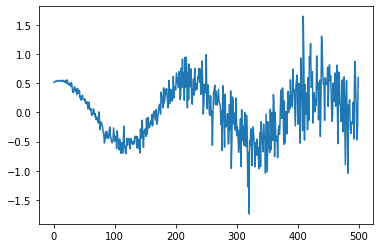

In [43]:
plt.figure()
plt.plot(X[0])
plt.show()

In [44]:
X.shape

(400, 500)

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, X)).batch(64)

# Defining a model

In [64]:
input_shape = X.shape[1:]
encoded_size = 6

In [65]:
input_shape

(500,)

In [66]:
prior = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros(encoded_size), scale=1
        ), reinterpreted_batch_ndims=1
    )

In [120]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(250),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(100),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(50),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(
        tfpl.MultivariateNormalTriL.params_size(encoded_size), 
        activation=None
    ),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=10.0)
        ),
])

In [121]:
encoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_48 (Batc (None, 250)               1000      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 250)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               25100     
_________________________________________________________________
batch_normalization_49 (Batc (None, 100)               400       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 100)             

In [122]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=encoded_size),
    tfkl.Dense(50),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(100),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(250),
    tfkl.BatchNormalization(),
    tfkl.LeakyReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
])

In [123]:
decoder.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 50)                350       
_________________________________________________________________
batch_normalization_51 (Batc (None, 50)                200       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               5100      
_________________________________________________________________
batch_normalization_52 (Batc (None, 100)               400       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 100)             

In [124]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs))

In [125]:
vae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_64 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_48 (Batc (None, 250)               1000      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 250)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               25100     
_________________________________________________________________
batch_normalization_49 (Batc (None, 100)               400 

# Train model

In [126]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset, 
            epochs=2000,
            callbacks = [tfk.callbacks.EarlyStopping(patience=50, monitor = 'loss', restore_best_weights=True)])

Epoch 1/2000
7/7 [==============================] - 3s 11ms/step - loss: 2376.5178
Epoch 2/2000
7/7 [==============================] - 0s 11ms/step - loss: 1615.0754
Epoch 3/2000
7/7 [==============================] - 0s 8ms/step - loss: 1610.5792
Epoch 4/2000
7/7 [==============================] - 0s 13ms/step - loss: 1218.1446
Epoch 5/2000
7/7 [==============================] - 0s 11ms/step - loss: 1118.0603
Epoch 6/2000
7/7 [==============================] - 0s 11ms/step - loss: 1134.1810
Epoch 7/2000
7/7 [==============================] - 0s 12ms/step - loss: 1106.7922
Epoch 8/2000
7/7 [==============================] - 0s 12ms/step - loss: 1101.7249
Epoch 9/2000
7/7 [==============================] - 0s 12ms/step - loss: 1081.0470
Epoch 10/2000
7/7 [==============================] - 0s 11ms/step - loss: 1026.2955
Epoch 11/2000
7/7 [==============================] - 0s 13ms/step - loss: 989.6655
Epoch 12/2000
7/7 [==============================] - 0s 12ms/step - loss: 977.1276
Epoc

# Generating samples

In [127]:
def get_latent_space_inputs(z, decoder, magnitude):
    z_np = z.numpy()
    results = []
    for i in range(z_np.shape[-1]):

        z_np_i_plus = z_np.copy()
        z_np_i_minus = z_np.copy()

        z_np_i_plus[0][i] += magnitude
        z_np_i_minus[0][i] -= magnitude
        z_i_plus = tf.convert_to_tensor(z_np_i_plus)
        z_i_minus = tf.convert_to_tensor(z_np_i_minus)

        results.append([z_i_minus, z, z_i_plus])
    
    return results

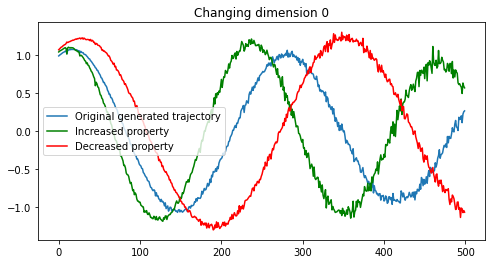

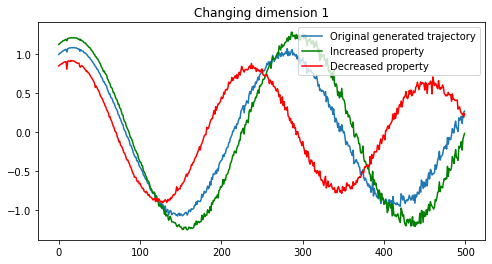

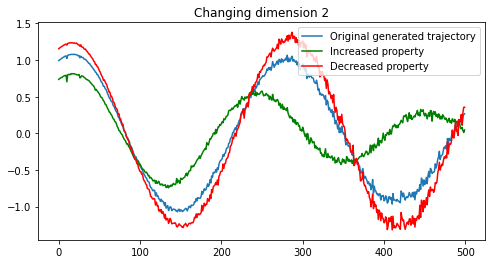

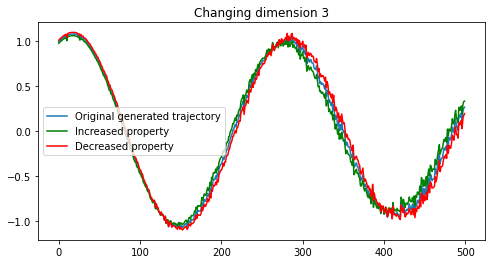

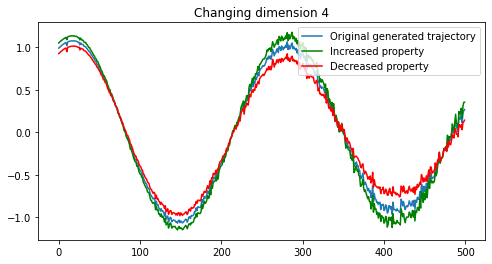

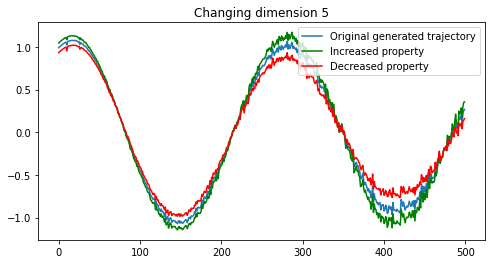

In [129]:
z = prior.sample(1)
xtilde = decoder(z)
ls_inputs = get_latent_space_inputs(z, decoder, 2)

for e, dimension_set in enumerate(ls_inputs):
    [z_i_minus, z_np, z_i_plus] = dimension_set
    xtilde_i = decoder(z_np)
    xtilde_i_plus = decoder(z_i_plus)
    xtilde_i_minus = decoder(z_i_minus)

    plt.figure(figsize=(8, 4))
    plt.title('Changing dimension ' + str(e))
    plt.plot(xtilde.mean().numpy().T, label = 'Original generated trajectory')
    plt.plot(xtilde_i_plus.mean().numpy().T, color = 'green', label = 'Increased property')
    plt.plot(xtilde_i_minus.mean().numpy().T, color = 'red', label = 'Decreased property')
    plt.legend()
    plt.show()